In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Local modules
sys.path.append('../src')
from train import train_model
from visualize import imshow, visualize_model
from utils import unpickle, save_pickle

In [2]:
def makeTransforms():
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    return data_transforms

def load_class_names(dataset_path=''):
    names = {}
    with open(os.path.join(dataset_path, 'classes.txt')) as f:
        for line in f:
            pieces = line.strip().split()
            class_id = pieces[0]
            names[class_id] = ' '.join(pieces[1:])
    return names

In [3]:
# Script runtime options
root_dir = '..' # '/home/jupyter/caltech_birds'
model = 'resnet152'
data_root_dir = os.path.join(root_dir, 'data_nabirds')
model_root_dir = os.path.join(root_dir, 'nabirds_models')
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images_sorted')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'na_birds_{}_full.pth'.format(model))

In [4]:
# Get data transforms
data_transforms = makeTransforms()

In [5]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}

class_labels = load_class_names(dataset_path=data_root_dir)
class_names = []
for class_id in image_datasets['test'].classes:
    class_names.append( '{} - {}'.format(class_id, class_labels[str(int(class_id))]) )
    
num_classes = len(class_names)

In [6]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


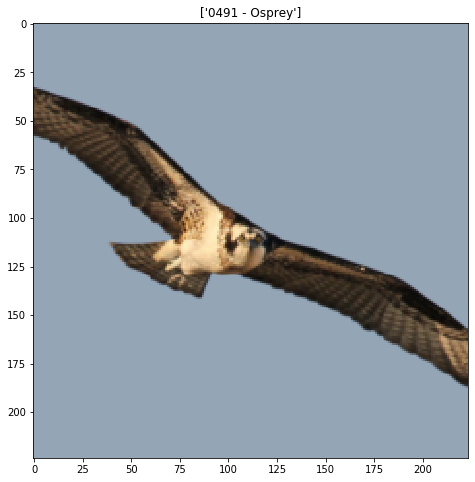

In [7]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
# Load the extracted feature maps
feature_maps_dict = unpickle(os.path.join(output_dir,'resnet152_feature_extractions.pkl'))
features = np.array(feature_maps_dict['feature extractions']).squeeze()

In [9]:
features.shape

(24633, 2048)

In [10]:
feature_maps_dict.keys()

dict_keys(['labels truth', 'labels pred', 'image paths', 'feature extractions'])

# Domain Reduction - Principal Components Analysis

## Assess all components

Compute all components to assess the number of components required to reconstruct 95% of the feature map information.

In [11]:
# Domain reduction
from sklearn.decomposition import PCA

In [12]:
pca = PCA()
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [13]:
cum_explained_variance_ratio= []
cumsum=0.
for comp in pca.explained_variance_ratio_:
    cumsum += comp
    cum_explained_variance_ratio.append( cumsum )

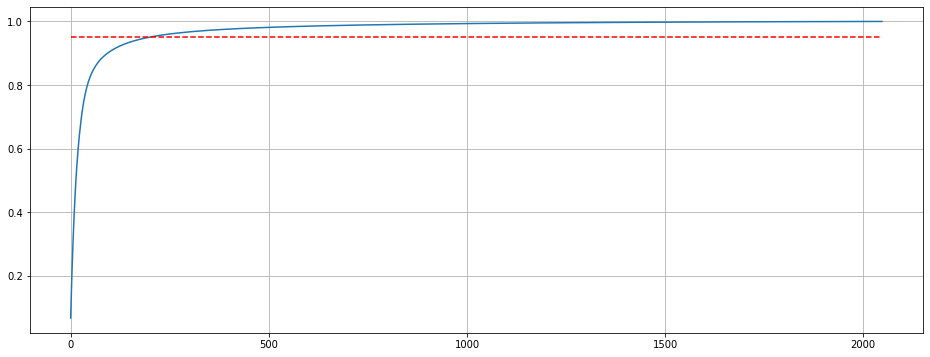

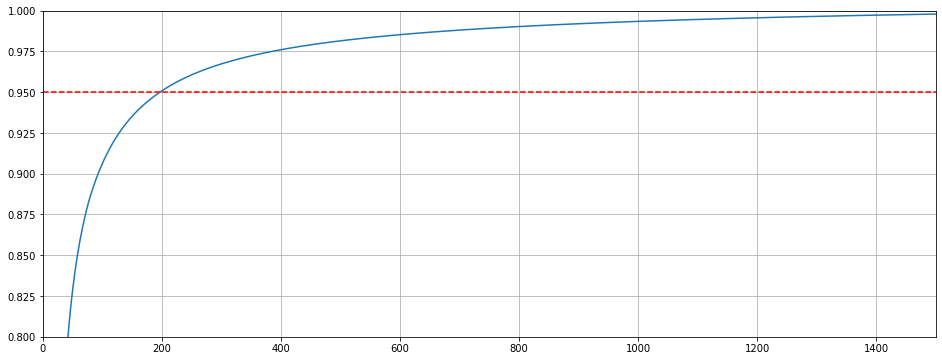

In [14]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(0,len(cum_explained_variance_ratio),1),cum_explained_variance_ratio)
plt.plot([0, len(cum_explained_variance_ratio)], [0.95, 0.95], 'r--')
plt.grid(True)
plt.yscale('linear')
plt.show()

plt.figure(figsize=(16,6))
plt.plot(np.arange(0,len(cum_explained_variance_ratio),1),cum_explained_variance_ratio)
plt.plot([0, len(cum_explained_variance_ratio)], [0.95, 0.95], 'r--')
plt.grid(True)
plt.yscale('linear')
plt.ylim([0.8,1.0])
plt.xlim([0, 1500])
plt.show()

## Compute the PCA transform and apply to the feature maps

200 components was found to recover ~95% of the variance in the data.
This is domain reduction from 2048 to 200 dimensions.

In [15]:
pca = PCA(n_components=200)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [16]:
pca_features = pca.transform(features)

In [17]:
pca_features.shape

(24633, 200)

In [18]:
pca_features_dict = {'pca_features' : pca_features,
                     'pca_model' : pca,
                     'n_components' : 200,
                     'cumulative explained variance ratio (all components)' : cum_explained_variance_ratio}

In [19]:
save_pickle(pca_features_dict, os.path.join(output_dir,'{}_pca_feature_extractions.pkl'.format(model)))

# Manifold Learning Representations


In [20]:
def get_manifold_df(trf_data, labels, class_names, img_paths):
    labels_name = []
    for label in labels:
        labels_name.append( class_names[label] )
    return pd.DataFrame({'Manifold Dim 1' : trf_data[:,0], 
                         'Manifold Dim 2' : trf_data[:,1], 
                         'label (truth)' : labels, 
                         'class name (truth)' : labels_name,
                         'image path' : img_paths})

## t-SNE of image feature maps

In [21]:
from sklearn.manifold import TSNE

In [22]:
tsne = TSNE(n_components=2, learning_rate=150, perplexity=50, angle=0.2, verbose=2).fit_transform(pca_features)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 24633 samples in 0.566s...
[t-SNE] Computed neighbors for 24633 samples in 236.680s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24633
[t-SNE] Computed conditional probabilities for sample 2000 / 24633
[t-SNE] Computed conditional probabilities for sample 3000 / 24633
[t-SNE] Computed conditional probabilities for sample 4000 / 24633
[t-SNE] Computed conditional probabilities for sample 5000 / 24633
[t-SNE] Computed conditional probabilities for sample 6000 / 24633
[t-SNE] Computed conditional probabilities for sample 7000 / 24633
[t-SNE] Computed conditional probabilities for sample 8000 / 24633
[t-SNE] Computed conditional probabilities for sample 9000 / 24633
[t-SNE] Computed conditional probabilities for sample 10000 / 24633
[t-SNE] Computed conditional probabilities for sample 11000 / 24633
[t-SNE] Computed conditional probabilities for sample 12000 / 24633
[t-SNE] Computed conditional probabilities for 

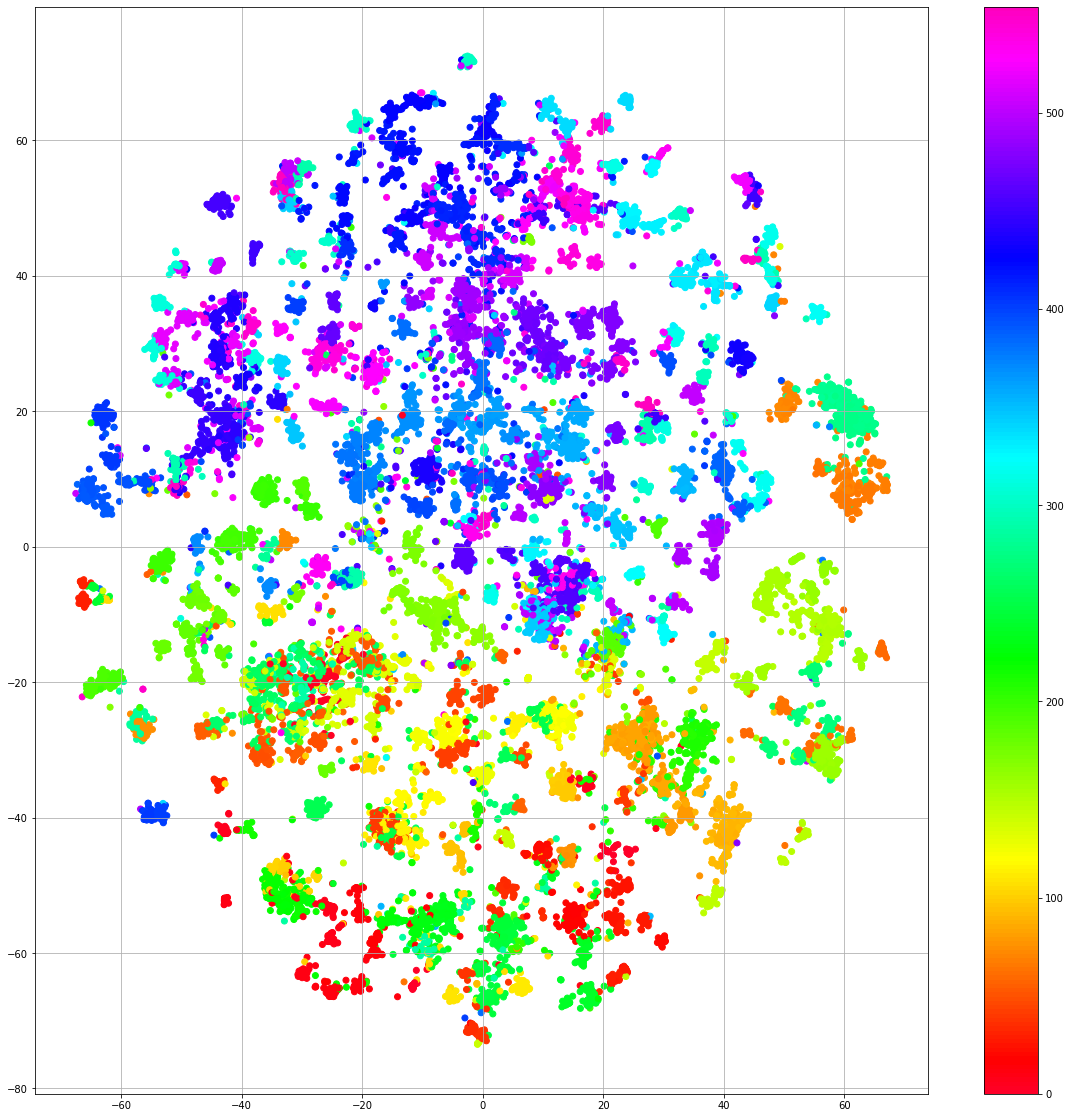

In [23]:
plt.figure(figsize=(20,20))
plt.scatter(tsne[:,0], tsne[:,1], c=feature_maps_dict['labels truth'], cmap='gist_rainbow')
plt.colorbar()
plt.grid(True)
plt.show()

In [24]:
tsne_df = get_manifold_df(trf_data=tsne, 
                          labels=feature_maps_dict['labels truth'], 
                          class_names=class_names, 
                          img_paths=feature_maps_dict['image paths'])

In [25]:
tsne_df

,Manifold Dim 1,Manifold Dim 2,label (truth),class name (truth),image path
0,-15.283446,-43.611561,250,0647 - Double-crested Cormorant (Adult),../data_nabirds/images_sorted/test/0647/fefcdd...
1,-2.796353,71.698959,300,0756 - Common Yellowthroat (Adult Male),../data_nabirds/images_sorted/test/0756/7d5ab2...
2,-2.664057,-2.333813,463,0919 - Brown-capped Rosy-Finch,../data_nabirds/images_sorted/test/0919/079c64...
3,-29.491055,-17.774315,4,0299 - Red-tailed Hawk (Light morph adult),../data_nabirds/images_sorted/test/0299/4e57dc...
4,45.577538,6.267715,321,0777 - Indigo Bunting (Adult Male),../data_nabirds/images_sorted/test/0777/7d6c1a...
...,...,...,...,...,...
24628,8.374444,-0.832763,327,0783 - Brown-headed Cowbird (Male),../data_nabirds/images_sorted/test/0783/48683c...
24629,30.098566,29.482378,525,0981 - Black-headed Grosbeak (Female/immature ...,../data_nabirds/images_sorted/test/0981/0fbd65...
24630,20.558165,-44.887543,0,0295 - Common Eider (Adult male),../data_nabirds/images_sorted/test/0295/fed880...
24631,23.311609,-35.797302,39,"0347 - Northern Gannet (Adult, Subadult)",../data_nabirds/images_sorted/test/0347/d29ad2...


In [26]:
from PIL import Image, ImageDraw, ImageFont
import io
import base64
import numpy
from skimage.util import img_as_uint, img_as_ubyte
from skimage.io import imsave

In [27]:
img_scale_factor = 0.5

In [28]:
def encode_image(im):
    rawBytes = io.BytesIO()    
    im = Image.fromarray(img_as_ubyte(np.array(im)))
    im.save(rawBytes, "PNG")
    rawBytes.seek(0) 
    encoded_image = base64.b64encode(rawBytes.read()).decode()
    return f'data:image/png;base64,{encoded_image}'

def add_class_to_image(im, classname, textfill=(255,255,255,255), textsize=0.75, textpos=(10,10)):
    # Add the class name to the image
    txt = Image.new('RGBA', (int(im.size[0]*textsize),int(im.size[1]*textsize)), (255,255,255,0))
    d = ImageDraw.Draw(txt)
    font = ImageFont.load_default()
    d.text(textpos, classname, font=font, fill=textfill)
    return Image.alpha_composite(im.convert('RGBA'), txt.resize(im.size))

In [29]:
run_encoding = True
if run_encoding:
    print('[INFO] Encoding images (100):', end='')
    encoded_images = []
    encoded_thumbs = []
    for i, image in enumerate(tsne_df['image path']):
        if (i % 100==0):
            print('|',end='')
        if (i % 1000==0):
            print('{}'.format(i),end='')
        im =  Image.open(image)
        im = add_class_to_image(im, tsne_df['class name (truth)'].iloc[i])
        encoded_image.append(encode_image(im))
        encoded_thumbs.append(encode_image(im.resize((int(im.size[0]*img_scale_factor), int(im.size[1]*img_scale_factor)), resample=3)))
    print(':')
    tsne_df['encoded image'] = encoded_images
    tsne_df['encoded image thumbs'] = encoded_thumbs
    tsne_df.to_pickle(os.path.join(output_dir,'{}_tsne_feature_extractions.pkl'.format(model)))
else:
    tsne_df = pd.read_pickle(os.path.join(output_dir,'{}_tsne_feature_extractions.pkl'.format(model)))

FileNotFoundError: [Errno 2] No such file or directory: '../nabirds_models/classification/resnet152/resnet152_tsne_feature_extractions.pkl'

In [ ]:
tsne_df

In [ ]:
import hvplot.pandas

In [ ]:
tsne_df.hvplot.scatter(x='Manifold Dim 1', 
                       y='Manifold Dim 2', 
                       by='label (truth)', 
                       frame_width=1000, 
                       frame_height=1000, 
                       hover_cols=['class name (truth)'], 
                       grid=True, cmap='gist_rainbow')

In [ ]:
from bokeh.plotting import ColumnDataSource, figure, output_file, show

min_index = 0
max_index = 4500
x=tsne_df['Manifold Dim 1'][min_index:max_index]
y=tsne_df['Manifold Dim 2'][min_index:max_index]

# get a colormap from matplotlib
colormap = plt.cm.get_cmap("gist_rainbow") #choose any matplotlib colormap here

# define maximum and minimum for cmap
colorspan=[0,200]

# create a color channel with a value between 0 and 1
# outside the colorspan the value becomes 0 (left) and 1 (right)
cmap_input=np.interp(tsne_df['label (truth)'][min_index:max_index],colorspan,[0,1],left=0,right=1)

# use colormap to generate rgb-values
# second value is alfa (not used)
# third parameter gives int if True, otherwise float
A_color=colormap(cmap_input,1,True)

# convert to hex to fit to bokeh
bokeh_colors = ["#%02x%02x%02x" % (r, g, b) for r, g, b in A_color[:,0:3]]

output_file("caltech_birds_resnet152_featuremaps_tsne_embedding.html")

source = ColumnDataSource(data=dict(
    x=x,
    y=y,
    imgs=tsne_df['encoded image thumbs'][min_index:max_index],
    classnames=tsne_df['class name (truth)'][min_index:max_index],
    colors=bokeh_colors
))

TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="100" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 17px; font-weight: bold;">@classnames</span>
            <span style="font-size: 15px; color: #966;">[$index]</span>
        </div>
    </div>
"""

p = figure(plot_width=1200, plot_height=1200, tooltips=TOOLTIPS,
           title="Mouse over the dots")

p.circle('x', 'y',fill_color='colors', line_color=None, size=5, source=source, fill_alpha=0.3, line_alpha=0.3)

show(p)


In [30]:
from matplotlib.pyplot import imshow
from PIL import Image
import random
import rasterfairy

ModuleNotFoundError: No module named 'rasterfairy'

In [31]:
num_images_to_plot = 2500

if len(tsne_df['image path']) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(tsne_df['image path'])), num_images_to_plot))
    #images = [tsne_df['image path'][i] for i in sort_order]
    tsne_df__plotting = pd.DataFrame([tsne_df.iloc[i] for i in sort_order])
else:
    tsne_df__plotting = tsne_df

In [ ]:
images = []
for id, path in zip(tsne_df__plotting.index,tsne_df__plotting['image path']):
    images.append(Image.open(path))
tsne_df__plotting['images'] = images

In [ ]:
tsne_df__plotting

In [ ]:
tx, ty = tsne_df__plotting['Manifold Dim 1'], tsne_df__plotting['Manifold Dim 2']
tsne_df__plotting['Norm Manifold Dim 1'] = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
tsne_df__plotting['Norm Manifold Dim 2'] = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

In [ ]:
tsne_df__plotting.hvplot.scatter(x='Norm Manifold Dim 1', 
                                 y='Norm Manifold Dim 2', 
                                 by='label (truth)', 
                                 frame_width=1000, 
                                 frame_height=1000, 
                                 hover_cols=['class name (truth)'], 
                                 grid=True, cmap='gist_rainbow')

In [ ]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(tsne_df__plotting['image path'], tsne_df__plotting['Norm Manifold Dim 1'], tsne_df__plotting['Norm Manifold Dim 2']):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

In [ ]:
plt.figure(figsize = (30,25))
plt.imshow(full_image)
plt.grid(True)
plt.show()

In [ ]:
# nx * ny = 1000, the number of images
nx = 50
ny = 50

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne_df__plotting[['Manifold Dim 1', 'Manifold Dim 2']].to_numpy(), target=(nx, ny))

In [ ]:
tile_width = 72
tile_height = 56

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(tsne_df__plotting['image path'], grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

plt.figure(figsize = (30,25))
plt.imshow(grid_image)
plt.show()

## UMAP of image feature maps

In [ ]:
from umap import UMAP

In [ ]:
umap = UMAP(n_neighbors=30,
            min_dist=0.05,
            n_components=2,
            metric='euclidean')

In [ ]:
umap_features = umap.fit_transform(pca_features)
umap_df = get_manifold_df(trf_data=umap_features, labels=feature_maps_dict['labels truth'], class_names=class_names)

In [ ]:
plt.figure(figsize=(20,20))
plt.scatter(umap_features[:,0], umap_features[:,1], c=feature_maps_dict['labels truth'], cmap='gist_rainbow')
plt.colorbar()
plt.grid(True)
plt.show()

In [ ]:
umap_df.hvplot.scatter(x='Manifold Dim 1', y='Manifold Dim 2', by='label (truth)', frame_width=1000, frame_height=1000, hover_cols=['class name (truth)'], grid=True, cmap='gist_rainbow')